<a href="https://colab.research.google.com/github/aderdouri/PINNs/blob/master/Tutorials/Inverse_pinn_bs_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Black-Scholes Partial Differential Equation (PDE)
The value of an option $V(S, t)$ satisfies the Black-Scholes PDE:
$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0
$$

### Initial and Boundary Conditions of the Black-Scholes PDE

The initial and boundary conditions for the Black-Scholes PDE depend on the type of derivative being priced, such as European call or put options. These conditions are necessary for solving the PDE and obtaining specific option prices. We will consider a Call option.

- $\textbf{Initial Condition}$ (at $t = T$):
    - $\text{Call: } V(S, T) = \max(S - K, 0)$ \\
- $\textbf{Boundary Conditions:}$
  - $V(0, t) = 0$ \\
  - $V(S, t) \to S - K e^{-r(T-t)} \quad \text{as } S \to \infty$

These conditions, combined with the Black-Scholes PDE, provide a complete specification for determining the price of the option.


## Implementation

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [22]:
def bs_pde_residual(model, S, t):
    """
    Compute the PDE residual for the Black-Scholes equation:
    dV/dt + 0.5 * sigma^2 * S^2 * d^2V/dS^2 + r * S * dV/dS - r * V = 0

    Args:
        model (torch.nn.Module): The PINN model that predicts V(S, t).
        S (torch.Tensor): Asset price tensor (requires_grad=True).
        t (torch.Tensor): Time tensor (requires_grad=True).

    Returns:
        torch.Tensor: The residual of the Black-Scholes PDE.
    """
    # Ensure gradients can be computed for S and t
    S.requires_grad = True
    t.requires_grad = True

    # Model prediction for V(S, t)
    V = model(S, t)

    # First-order derivative w.r.t. S
    V_S = torch.autograd.grad( V, S, grad_outputs=torch.ones_like(V), create_graph=True)[0]

    # First-order derivative w.r.t. t
    V_t = torch.autograd.grad(V, t, grad_outputs=torch.ones_like(V), create_graph=True)[0]

    # Second-order derivative w.r.t. S
    V_SS = torch.autograd.grad(V_S, S, grad_outputs=torch.ones_like(V_S), create_graph=True)[0]

    # PDE residual
    residual = V_t + 0.5 * (model.sigma)**2 * S**2 * V_SS + model.r * S * V_S - model.r * V

    # Debugging prints (optional, for tracking intermediate values)
    #if torch.isnan(residual).any():
    #    print("NaN detected in residual!")
    #print(f"V_t: {V_t.mean().item()}, V_S: {V_S.mean().item()}, V_SS: {V_SS.mean().item()}, Residual: {residual.mean().item()}")

    return residual

# Step 2: Define the PINN model
import torch
import torch.nn as nn

class PINN(nn.Module):
    """Physics-Informed Neural Network for Black-Scholes equation."""
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = nn.Sequential(
            nn.Linear(2, 50),  # Inputs: (S, t)
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Output: V(S, t)
        )

        # Define r and sigma as trainable parameters
        self.r = nn.Parameter(torch.tensor(0.04, dtype=torch.float32, requires_grad=True))
        self.sigma = nn.Parameter(torch.tensor(0.30, dtype=torch.float32, requires_grad=True))


        # Trainable unconstrained parameters
        #self.log_sigma = nn.Parameter(torch.tensor(0.1, requires_grad=True))  # Log of sigma
        #self.log_r = nn.Parameter(torch.tensor(0.01, requires_grad=True))      # Log of r

        # Initialize weights
        self.init_weights()


    def forward(self, x):
         return self.hidden_layers(x)

    def init_weights(self):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)

    #def init_weights(self):
    #    for m in self.hidden_layers:
    #        if isinstance(m, nn.Linear):
    #            nn.init.xavier_normal_(m.weight)  # Xavier initialization
    #            nn.init.constant_(m.bias, 0)  # Bias initialized to zero


    def forward(self, S, t):
        input_tensor = torch.cat((S, t), dim=1)  # Combine S and t
        return self.hidden_layers(input_tensor)

    def print_params(self):
        print(f"r: {self.r.item():.6f}, sigma: {self.sigma.item():.6f}")


# Step 3: Define the loss function
def compute_loss(model, S_collocation, t_collocation,
                 S_boundary, t_boundary, V_boundary,
                 S_initial, t_initial, V_initial,
                 S_observed, t_observed, V_observed, epoch=0):
    # PDE residual loss
    residual = bs_pde_residual(model, S_collocation, t_collocation)
    pde_loss = torch.mean(residual**2)

    # Boundary condition loss
    V_boundary_low_pred = model(S_boundary[0], t_boundary)
    V_boundary_high_pred = model(S_boundary[1], t_boundary)
    bc_loss = torch.mean((V_boundary_low_pred - V_boundary[0])**2) + \
              torch.mean((V_boundary_high_pred - V_boundary[1])**2)

    # Initial condition loss
    V_initial_pred = model(S_initial, t_initial)
    ic_loss = torch.mean((V_initial_pred - V_initial)**2)

    # Observed data loss
    V_observed_pred = model(S_observed, t_observed)
    observed_loss = torch.mean((V_observed_pred - V_observed)**2)

    total_loss = pde_loss + bc_loss + ic_loss + observed_loss
    return total_loss


# Step 4: Training the model
def train_pinn(model, S_collocation, t_collocation,
               S_boundary, t_boundary, V_boundary,
               S_initial, t_initial, V_initial,
               S_observed, t_observed, V_observed,
               adam_epochs=1000, lbfgs_epochs=500):
    """Train the PINN model using Adam and LBFGS optimizers."""
    # Adam optimizer for initial training
    optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(adam_epochs):
        optimizer_adam.zero_grad()
        loss = compute_loss(model, S_collocation, t_collocation,
                            S_boundary, t_boundary, V_boundary,
                            S_initial, t_initial, V_initial,
                            S_observed, t_observed, V_observed, epoch)
        loss.backward()
        optimizer_adam.step()
        if epoch % 100 == 0:
          print(f"Epoch {epoch}, Sigma Gradient: {model.sigma.grad}, r Gradient: {model.r.grad}")
          print(f"Epoch {epoch}, Loss: {loss.item():.6f}, r: {model.r.item():.6f}, sigma: {model.sigma.item():.6f}")


    for name, param in model.named_parameters():
        if param.requires_grad:
            print('param.requires_grad:', name)


    # LBFGS optimizer for fine-tuning
    optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=lbfgs_epochs,
                                        tolerance_grad=1e-7, tolerance_change=1e-9)

    lbfgs_iter = 0
    def closure():
        nonlocal lbfgs_iter
        optimizer_lbfgs.zero_grad()
        loss = compute_loss(model, S_collocation, t_collocation,
                            S_boundary, t_boundary, V_boundary,
                            S_initial, t_initial, V_initial,
                            S_observed, t_observed, V_observed, 1)
        loss.backward()
        if lbfgs_iter % 100 == 0:
            print(f"LBFGS Iteration {lbfgs_iter}, Loss: {loss.item():.6f}, r: {model.r.item():.6f}, sigma: {model.sigma.item():.6f}")

        lbfgs_iter += 1

        return loss

    print("Starting LBFGS optimization...")
    optimizer_lbfgs.step(closure)

In [23]:
# Parameters
S_min, S_max = 50.0, 150.0
T = 5.0
K = 100.0
r_true = 0.05
sigma_true = 0.2

# Generate observed data using Black-Scholes analytic formula
def bs_analytic_call(S, t, K, r, sigma, T):
    d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * torch.sqrt(T - t))
    d2 = d1 - sigma * torch.sqrt(T - t)
    C = S * torch.distributions.Normal(0, 1).cdf(d1) - K * torch.exp(-r * (T - t)) * torch.distributions.Normal(0, 1).cdf(d2)
    return C

# Collocation points
n_collocation = 5000
S_collocation = torch.rand(n_collocation, 1) * (S_max - S_min) + S_min
t_collocation = torch.rand(n_collocation, 1) * T

# Normalize inputs
S_collocation_norm = (S_collocation - S_min) / (S_max - S_min)
t_collocation_norm = t_collocation / T

# Boundary points
t_boundary = torch.linspace(0, T, 100).view(-1, 1)
S_boundary_low = torch.full_like(t_boundary, S_min)
S_boundary_low_norm = (S_boundary_low - S_min) / (S_max - S_min)

S_boundary_high = torch.full_like(t_boundary, S_max)
S_boundary_high_norm = (S_boundary_high - S_min) / (S_max - S_min)
S_boundary_norm = [S_boundary_low_norm, S_boundary_high_norm]

V_boundary_low = torch.zeros_like(t_boundary)
V_boundary_high = S_max - K * torch.exp(-r_true * (T - t_boundary))
V_boundary = [V_boundary_low, V_boundary_high]

t_boundary_norm = t_boundary / T

# Initial points
S_initial = torch.linspace(S_min, S_max, 100).view(-1, 1)
t_initial = torch.full_like(S_initial, T)
V_initial = torch.maximum(S_initial - K, torch.tensor(0.0))

S_initial_norm = (S_initial - S_min) / (S_max - S_min)
t_initial_norm = t_initial / T

# Observed data
n_observed = 100
S_observed = torch.rand(n_observed, 1) * (S_max - S_min) + S_min
t_observed = torch.rand(n_observed, 1) * T
V_observed = bs_analytic_call(S_observed, t_observed, K, r_true, sigma_true, T)

S_observed_norm = (S_observed - S_min) / (S_max - S_min)
t_observed_norm = t_observed / T

In [25]:
# Step 6: Initialize and train the PINN
model = PINN()
train_pinn(model, S_collocation_norm, t_collocation_norm,
           S_boundary_norm, t_boundary_norm, V_boundary,
           S_initial_norm, t_initial_norm, V_initial,
           S_observed_norm, t_observed_norm, V_observed,
           adam_epochs=10000, lbfgs_epochs=50000)

Epoch 0, Sigma Gradient: 0.038471851497888565, r Gradient: 0.08325950056314468
Epoch 0, Loss: 5302.080566, r: 0.039000, sigma: 0.299000
Epoch 100, Sigma Gradient: 5.228875637054443, r Gradient: 5.8222198486328125
Epoch 100, Loss: 3149.725586, r: -0.054630, sigma: 0.174098
Epoch 200, Sigma Gradient: 3.4755892753601074, r Gradient: 1.0164947509765625
Epoch 200, Loss: 2517.937988, r: -0.112332, sigma: 0.051663
Epoch 300, Sigma Gradient: 0.3745581805706024, r Gradient: -13.191024780273438
Epoch 300, Loss: 2007.347656, r: -0.066486, sigma: 0.003988
Epoch 400, Sigma Gradient: -0.0029054887127131224, r Gradient: -8.700088500976562
Epoch 400, Loss: 1552.056641, r: 0.128988, sigma: -0.000019
Epoch 500, Sigma Gradient: -1.5236151739372872e-05, r Gradient: 0.29822540283203125
Epoch 500, Loss: 1211.959229, r: 0.153150, sigma: -0.000000
Epoch 600, Sigma Gradient: -6.450630962717696e-08, r Gradient: -0.3771514892578125
Epoch 600, Loss: 950.636963, r: 0.152746, sigma: -0.000000
Epoch 700, Sigma Gradi

In [13]:
#torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True, precision=6)

# Step 7: Visualize the results
# Create a grid for prediction
S_pred = torch.linspace(S_min, S_max, 100).view(-1, 1)
S_pred_norm = (S_pred - S_min) / (S_max - S_min)

t_pred = torch.linspace(0, T, 100).view(-1, 1)
t_pred_norm = (t_pred - 0) / (T - 0)
S_grid_pred, t_grid_pred = torch.meshgrid(S_pred_norm.squeeze(), t_pred_norm.squeeze(),
                                          indexing='ij')
S_flat = S_grid_pred.flatten().view(-1, 1)
t_flat = t_grid_pred.flatten().view(-1, 1)

# Make predictions using the trained model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for inference
    V_pred = model(S_flat, t_flat).detach().numpy()

V_pred = V_pred.reshape(100, 100)
print(V_pred)


# black_scholes(S, t, T, K, r, sigma)
S_grid_pred, t_grid_pred = torch.meshgrid(S_pred.squeeze(), t_pred.squeeze(),
                                          indexing='ij')
S_flat = S_grid_pred.flatten().view(-1, 1)
t_flat = t_grid_pred.flatten().view(-1, 1)
#V_exact = bs_analytic_call(S_flat, t_flat, T, K, r_true, sigma_true)
V_exact = bs_analytic_call(S_flat, t_flat, K, r_true, sigma_true, T)

V_exact = V_exact.reshape(100, 100)
print(V_exact.detach().numpy())

[[-0.058367 -0.044451 -0.032021 ...  0.041041  0.041479  0.041433]
 [ 1.088927  1.094535  1.099447 ...  0.68153   0.670618  0.659367]
 [ 1.235805  1.238941  1.241646 ...  0.78454   0.772581  0.759977]
 ...
 [70.26583  70.090965 69.91404  ... 48.46161  48.193356 47.950745]
 [71.221275 71.046104 70.86884  ... 49.51194  49.229168 48.96377 ]
 [72.1784   72.00293  71.825356 ... 50.564785 50.267498 49.978695]]
[ 0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.505051  1.515152  2.525253  3.535355  4.545456  5.555557
  6.565659  7.57576   8.585861  9.595963 10.606064 11.616165 12.62

In [15]:
V_exact[:, 99], V_pred[:, 99]

(tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.5051,  1.5152,  2.5253,  3.5354,  4.5455,  5.5556,
          6.5657,  7.5758,  8.5859,  9.5960, 10.6061, 11.6162, 12.6263, 13.6364,
         14.6465, 15.6566, 16.6667, 17.6768, 18.6869, 19.6970, 20.7071, 21.7172,
         22.7273, 23.7374, 24.7475, 25.7576, 26.7677, 27.7778, 28.7879, 29.7980,
         30.8081, 31.8182, 32.8283, 33.8384, 34.8485, 35.8586, 36.8687, 37.8788,
         38.8889, 39.8990, 40.9091, 41.9192, 42.9293, 43.9394, 44.9495, 45.9596,
         46.9697, 47.9798, 4

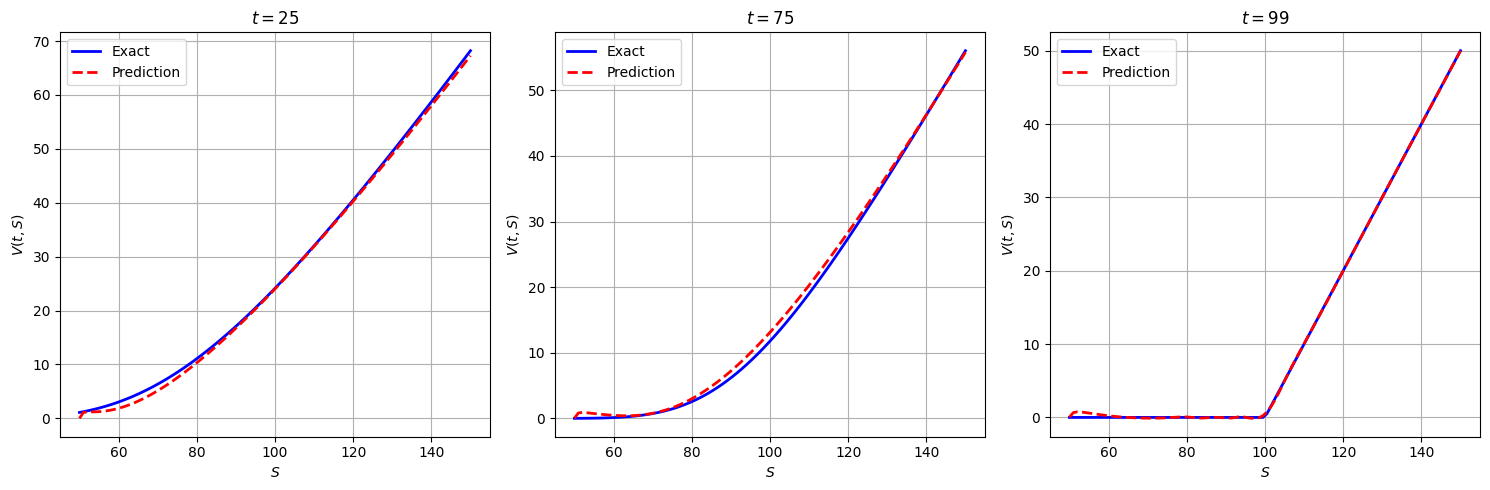

In [12]:
# Step 8: Compare predictions with exact solution at specific time slices
time_slices = [25, 75, 99]  # Time slices to compare

plt.figure(figsize=(15, 5))

for i, t_slice in enumerate(time_slices):
    # Extract points for the time slice
    t_slice_tensor = torch.full_like(S_pred, t_slice)
    V_pred_slice = V_pred[:, t_slice]

    # Compute exact solution
    V_exact_slice = V_exact[:,t_slice]

    # Plot comparison
    plt.subplot(1, 3, i + 1)
    plt.plot(S_pred.numpy(), V_exact_slice, 'b-', label='Exact', linewidth=2)
    plt.plot(S_pred.numpy(), V_pred_slice, 'r--', label='Prediction', linewidth=2)
    plt.title(f"$t = {t_slice}$")
    plt.xlabel("$S$")
    plt.ylabel("$V(t, S)$")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()
